## Analyzing and generating configuration files for Helios
Igor Morozov  
© HB11 Energy, 2025  

### General definitions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re, os, time, subprocess
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime
from typing import List
#import json
#import warnings

In [4]:
# Directories and file names
heliosExe = r"c:\Program Files\Prism\Helios_10.1.0\bin\win64\Helios.exe"
heliosDir = r"c:\Users\Igor\Documents\Temp\helios"

In [5]:
# Common variables
ns = 1e-9  # nanoseconds in seconds
ps = 1e-12  # picoseconds in seconds
mg = 1e-3     # milligram in grams
um = 1e-4   # micrometer in cm
frscale = 1e34  # scale factor for the fusion rate
pl_font_size = 10

### Generate Helios configurations

#### Generate the source file for burn propagation

In [6]:
# Helper to create regex replacement patterns
def RHWRule(var: str, value: str):
    pattern = rf"(\n\s+{re.escape(var)}\s+=)\s\S+"
    replacement = rf"\1 {value}"
    return pattern, replacement

def RHWRuleReal(var: str, value: float):
    return RHWRule(var, f"{value:.6g}")  # 6 significant digits

def RHWRuleInt(var: str, value: float):
    return RHWRule(var, str(int(value)))

# Main function
def GenRHW2(jconf, overwrite=False):
    if isinstance(jconf, list):
        for conf in jconf:
            GenRHW2(conf, overwrite)
        return

    templname = jconf.get("templ", "")
    template_path = os.path.join(heliosDir, jconf["dir"], f"template{templname}.rhw")

    with open(template_path, "r", encoding="utf-8") as f:
        content = f.read()

    # Find region positions
    search_strings = ["Spatial Grid Data", "Parameters for Region"]
    region_pos = []
    for s in search_strings:
        start = 0
        while True:
            idx = content.find(s, start)
            if idx == -1:
                break
            region_pos.append(idx)
            start = idx + 1
    region_pos.sort()

    # Split into regions
    split_points = [0] + region_pos + [len(content)]
    regions = [content[split_points[i]:split_points[i+1]] for i in range(len(split_points)-1)]

    # === First Region ===
    replacements = [
        RHWRuleReal("Region width", jconf["R1"]),
        RHWRuleInt("Min. radius", 0),
        RHWRuleReal("Max. radius", jconf["R1"]),
        RHWRuleReal("Density", jconf["rho1"]),
        RHWRuleReal("Temperature", jconf["Ti1"]),
        RHWRuleReal("Electron Temperature", jconf["Te1"]),
        RHWRuleReal("Radiation Temperature", jconf["Tr1"]),
        RHWRuleInt("Est. num zones", floor(jconf["zn1"]))
    ]
    for pat, repl in replacements:
        regions[2] = re.sub(pat, repl, regions[2])

    # === Second Region ===
    replacements = [
        RHWRuleReal("Region width", jconf["dR2"]),
        RHWRuleReal("Min. radius", jconf["R1"]),
        RHWRuleReal("Max. radius", jconf["R2"]),
        RHWRuleReal("Density", jconf["rho2"]),
        RHWRuleReal("Temperature", jconf["T2"]),
        RHWRuleReal("Electron Temperature", jconf["T2"]),
        RHWRuleReal("Radiation Temperature", jconf["Tr2"]),
        RHWRuleInt("Est. num zones", floor(jconf["zn2"]))
    ]
    for pat, repl in replacements:
        regions[3] = re.sub(pat, repl, regions[3])

    # === Common part ===
    replacements = [
        RHWRuleReal("Max simulation time", jconf["s_time"] * ps)
    ]
    for pat, repl in replacements:
        regions[4] = re.sub(pat, repl, regions[4])

    # === Save output ===
    out_path = os.path.join(heliosDir, jconf["dir"], f"{jconf['name']}.rhw")
    if not overwrite and os.path.exists(out_path):
        raise FileExistsError(f"{out_path} already exists and overwrite=False")
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("".join(regions) + "\n")

### Run Helios

In [7]:
# Execute Helios for a single input file
def execute_Helios(dir_name: str, runname: str):
  print("Helios started on", datetime.now().strftime("%d/%m/%Y %H:%M:%S"),"...")
  start = time.time()
  try:
    result = subprocess.run([heliosExe, "-b", "-x", "-i", f"{runname}.rhw"],
                            cwd=os.path.join(heliosDir, dir_name), capture_output=True, text=True, check=True)
  except subprocess.CalledProcessError as e:
    print(f"Error executing command: {e}\n{e.stderr}")
  if( result.stderr.startswith("Unable to access workspace") ):
    raise RuntimeError(f"Error executing Helios: {result.stderr.splitlines()[0]}")
  exec_time = time.time() - start
  #print(f"Completed, execution time is", time.strftime("%H:%M:%S", time.gmtime( round(exec_time) )))
  return exec_time

### Load Helios simulation results

#### Definitions for the reader

In [8]:
# Dataset name mapping
hel_dataset_names = {
    "t": "time_whole",
    "idxr": "Indices at region interfaces",
    "zones": "zone_boundaries",
    "rho": "mass_density",
    "ni": "ion_density",
    "ne": "elec_density",
    "Ti": "ion_temperature",
    "Te": "elec_temperature",
    "Tr": "radiation_temperature",
    "Eti": "TotIonInternalEn",
    "Ete": "TotEleInternalEn",
    "Ei": "ion_specific_internal_energy",
    "Ee": "elec_specific_internal_energy",
    "pi": "ion_pressure",
    "pe": "elec_pressure",
    "Z": "mean_charge",
    "frDT": "FusionRate_DT_nHe4",
    "frpB": "FusionRate_pB11_3He4",
    "Er": "EnTotRadiation",
    "Ek": "TotKineticEnergy",
    "Erloss": "TimeIntRadiationLossAtBds",
    "Fetor": "EnExchEleToRadTimeIntg",
    "Wrheat": "heating_term",
    "Wrcool": "cooling_term"
}

# Conversion factors
hel_dataset_conv = {
    "t": 1/ps,
    "rho": 1,
    "ni": 1,
    "ne": 1,
    "Ti": 1e-3,
    "Te": 1e-3,
    "Tr": 1e-3,
    "Eti": 1e-6,
    "Ete": 1e-6,
    "Ei": 1e-6,
    "Ee": 1e-6,
    "pi": 1,
    "pe": 1,
    "Z": 1,
    "frDT": 1/frscale,
    "frpB": 1/frscale,
    "Er": 1e-6,
    "Ek": 1e-6,
    "Erloss": 1e-6,
    "Fetor": 1e-6,
    "Wrheat": 1e-6,
    "Wrcool": 1e-6
}

# Units (optional metadata)
hel_dataset_units = {
    "t": "ps",
    "rho": "g/cm^3",
    "ni": "1/cm^3",
    "ne": "1/cm^3",
    "Ti": "keV",
    "Te": "keV",
    "Tr": "keV",
    "Eti": "MJ",
    "Ete": "MJ",
    "Ei": "MJ",
    "Ee": "MJ",
    "pi": "J/cm^3",
    "pe": "J/cm^3",
    "Z": "",
    "frDT": f"{frscale} g^-1 s^-1",
    "frpB": f"{frscale} g^-1 s^-1",
    "Er": "MJ",
    "Ek": "MJ",
    "Erloss": "MJ",
    "Fetor": "MJ",
    "Wrheat": "MJ",
    "Wrcool": "MJ"
}

# Fusion rate label
def frlabel():
    return f"Fusion rate, {frscale} g^-1 s^-1"

#### Exo file reader

In [9]:
# NetCDF4 .exo file reader
def import_exo_datasets(filepath, varnames):
    """
    Reads datasets from a NetCDF/HDF .exo file using netCDF4.
    varnames: list of NetCDF variable names to read.
    Returns: list of numpy arrays in the same order as varnames.
    """
    out_data = []
    with Dataset(filepath, "r") as nc:
        for v in varnames:
            if v not in nc.variables:
                raise KeyError(f"Variable '{v}' not found in {filepath}")
            out_data.append(nc.variables[v][:])
    return out_data

# Main function
def ReadHeliosExoC(dir_name, runname, varlist):
    """
    Reads Helios .exo output and returns a dictionary of results.
    varlist: list of variable short keys ('rho', 'Ti', etc.)
    """
    pos_t, pos_i, pos_z = 0, 1, 2  # Python zero-based indexes
    
    datasets = ["t", "idxr", "zones"] + varlist
    dataset_names = [hel_dataset_names[v] for v in datasets]

    # Path to the file
    exo_path = os.path.join(heliosDir, dir_name, runname, runname + ".exo")
    if not os.path.exists(exo_path):
        raise RuntimeError(f"Input file is not found: {exo_path}")

    # Load datasets from NetCDF4
    data = import_exo_datasets(exo_path, dataset_names)

    ncycles = len(data[pos_t])
    idxr = (np.concatenate(([1], np.array(data[pos_i][0], dtype=int))) - 1).tolist()
    nreg = len(idxr) - 1

    result = {
        "dir": dir_name,
        "runname": runname,
        "geometry": "PLANAR" if dir_name.endswith("planar") else "SPHERICAL",
        "nt": ncycles,
        "t": np.array(data[pos_t]) * hel_dataset_conv["t"],
        "tstart0": True,
        "idxr": idxr,
        "idxc": [round(np.mean(idxr[i:i+2])) for i in range(nreg)],
        "nreg": nreg,
        "reg": np.array(data[pos_z][0])[idxr[1:]],
        "zones": data[pos_z],
        "nr": len(data[pos_z][0]) - 1,
        "r": [
            (np.array(data[pos_z][i][1:]) + np.array(data[pos_z][i][:-1])) / 2
            for i in range(ncycles)
        ]
    }

    # Add user-requested variables
    for iv, var in enumerate(varlist):
        arr = np.array(data[iv + 3])
        result[var] = arr * hel_dataset_conv[var]

    return result

#### Extract per-region and overall properties from the Helios data

In [10]:
# === Volume of spherical layer ===
def LVol(r1, r2):
    """Volume of spherical layer between r1 and r2 (cm^3)."""
    return (4 * np.pi / 3) * (r2**3 - r1**3)

# === Region value extraction ===
def RegVal(hel, var):
    """
    Extract a value array for variable 'var' at the central zone
    of each region for the first time step.
    """
    return hel[var][0, hel["idxc"]]

def RegVals(hel, vars, ireg=0):
    """
    Extract a list of values for variables 'vars'
    in region index ireg at the first time step.
    """
    return [hel[v][0, hel["idxc"][ireg]] for v in vars]

# === Region masses ===
def RegMass(hel):
    """Mass of each region at the first time step (grams)."""
    r = hel["reg"]
    rho = RegVal(hel, "rho")
    masses = []
    for ireg in range(hel["nreg"]):
        r1 = 0 if ireg == 0 else r[ireg-1]
        r2 = r[ireg]
        masses.append(rho[ireg] * LVol(r1, r2))
    return np.array(masses)

def RegMassTot(hel):
    """Total mass over all regions (grams)."""
    return np.sum(RegMass(hel))

#### Plot helper functions

In [11]:
# ---------- Helper functions ----------
def RdepcMu(hel, var, cycle, factor=1.0):
    """Return R (μm) vs variable at a given cycle, with optional scaling factor."""
    R_um = hel["r"][cycle] / um
    values = hel[var][cycle] * factor
    return np.column_stack((R_um, values))

def timeToCycle(hel, time):
    if "tstart0" in hel:
        return 1 + round(time / hel["t"][1])
    else:
        return 1 + round((time - hel["t"][0]) / (hel["t"][1] - hel["t"][0]))

In [12]:
# Returns cycle, time, and maximal value of the given variable
def findMaxValue(hel, var):
  max_each_cycle = np.max(hel["rho"], axis=1)
  cycle = np.argmax(max_each_cycle)
  time = hel["t"][cycle]
  val = np.max(hel["rho"][cycle])
  return (cycle, time, val)

#### Plot density and temperature

In [34]:
def plot_rho_and_Ti(hel, cycle, rmax=1000):
  # ---------- Data preparation ----------
  time_ns = hel["t"][cycle] / 1e3
  Rlimits = (0, rmax)  # μm
  cols = ["tab:blue", "tab:red"]
  # ---------- Prepare curves ----------
  rho_data = RdepcMu(hel, "rho", cycle)  # g/cm³
  Ti_data = RdepcMu(hel, "Ti", cycle)    # keV
  # ---------- Plot ----------
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
  # ----- Left plot: Max ρ -----
  ax1.plot(hel["t"], np.max(hel["Ti"], axis=1), linestyle='-')
  ax1.set_xlabel("t, ps", fontsize=pl_font_size)
  ax1.set_ylabel(r"Max $T_\mathrm{i}$, keV", fontsize=pl_font_size)
  ax1.grid(True, linestyle="--", alpha=0.6)
    # ----- Right plot: ρ & Ti -----
  ax2.plot(rho_data[:, 0], rho_data[:, 1], color=cols[0], label=r"$\rho$")
  ax2.set_xlim(Rlimits)
  ax2.set_xlabel(r"R, $\mu$m", fontsize=pl_font_size)
  ax2.set_ylabel(r"$\rho$, g/cc", color=cols[0], fontsize=pl_font_size)
  ax2.tick_params(axis='y', labelcolor=cols[0])
  # Twin y-axis for Ti
  ax2_twin = ax2.twinx()
  ax2_twin.plot(Ti_data[:, 0], Ti_data[:, 1], color=cols[1], label=r"$T_i$")
  ax2_twin.set_ylabel(r"$T_i$, keV", color=cols[1], fontsize=pl_font_size)
  ax2_twin.tick_params(axis='y', labelcolor=cols[1])
  # Title above second plot
  ax2.set_title(fr"$t = {time_ns:.2f}$ ns", fontsize=pl_font_size)
  # Adjust layout
  plt.tight_layout()
  plt.show()

### Tests

#### Test reader

Number of zones: 160, number of cycles: 502


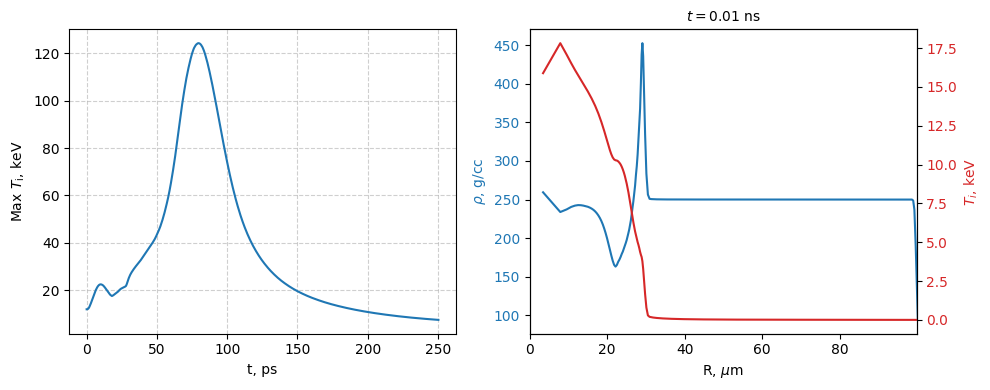

In [38]:
hel = ReadHeliosExoC("dt_triforce", "DT_rho250Ti12Tr2a1H0.6M1", ["rho", "Ti", "Te", "Eti", "Ete", "Ei", "Ee", "pi"])
print(f"Number of zones: {hel['nr']}, number of cycles: {hel['nt']}")
cycle = int(10 / hel['t'][2])  # in ps
rmax = hel['r'][1][-1]
plot_rho_and_Ti(hel, cycle, rmax/um)